# Compare InSAR and GNSS LOS velocities

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

In [38]:
with rasterio.open('velocity.tif', 'r') as f:
    xy = f.xy
    trans = f.transform
    crs = f.crs
    bounds = f.bounds
    vel = f.read(1)

x = np.array([trans[2] + trans[0]*k for k in range(vel.shape[1])])
y = np.array([trans[5] + trans[4]*k for k in range(vel.shape[0])])

In [39]:
print(x.shape)
print(y.shape)
[X, Y] = np.meshgrid(x, y)
print(X.shape)
print(vel.shape)

(3603,)
(2915,)
(2915, 3603)
(2915, 3603)


In [42]:
vel[vel==0.] = np.nan

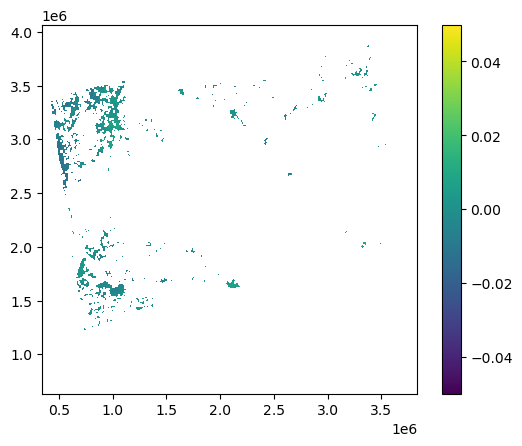

In [43]:
cax = plt.imshow(vel, vmin=-0.05, vmax=0.05, extent=bounds)
cbar = plt.colorbar(cax)
plt.show()

In [ ]:
# add in loading gnss file using pandas (see gnss notebook for example)

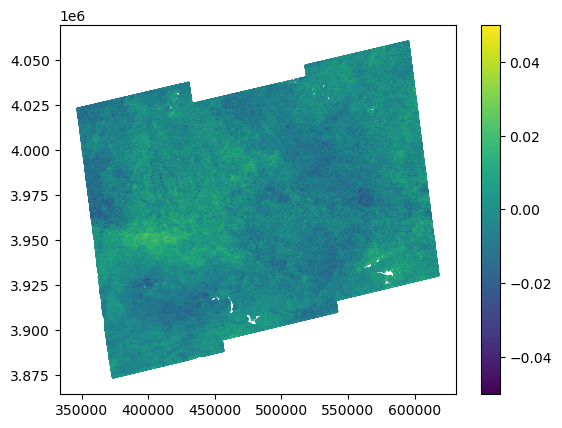

In [44]:
cax = plt.scatter(X.ravel(), Y.ravel(), c=vel.ravel(), s = 1, marker='.', vmin=-0.05, vmax=0.05)

# uncomment the line below after loading in gnss data
# plt.scatter(df['gnss_x'], df['gnss_y'], c=df['LOS_VEL'], vmax=0.05, vmin=-0.05, marker='o')

cbar = plt.colorbar(cax)
plt.show()

In [ ]:
# interpolate insar velocities to GNSS_x and y and calculate RMSE
vel_Insar = 0 # need to interpolate to gnss locations (use RegularGridInterpolator)

# calculate RMSE
rmse = np.sqrt(np.sum(np.square(vel_Insar - df['LOS_VEL'])))

print(rmse)